In [1]:
import tensorflow as tf

2024-04-08 12:18:17.832969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 12:18:21.510952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "DN121_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./DN121models/'+str(start_epoch-1)+model_name)
else:
    input_shape = (30, 30, 168)
    num_classes = 4
    model = densenet(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-08 12:25:49.695863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14708 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 30, 168)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 15, 15, 64)           526912    ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['max_pooling2d[0][0]']   

 )                                                                   'concatenate_2[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 8, 8, 192)            768       ['concatenate_3[0][0]']       
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 8, 8, 192)            0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 128)            24704     ['re_lu_8[0][0]']             
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_17 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_16[0][0]']            
                                                                                                  
 concatenate_7 (Concatenate  (None, 4, 4, 192)            0         ['conv2d_17[0][0]',           
 )                                                                   'concatenate_6[0][0]']       
                                                                                                  
 batch_normalization_17 (Ba  (None, 4, 4, 192)            768       ['concatenate_7[0][0]']       
 tchNormalization)                                                                                
                                                                                                  
 re_lu_17 (ReLU)             (None, 4, 4, 192)            0         ['batch_normalization_17[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_25 (ReLU)             (None, 4, 4, 320)            0         ['batch_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 4, 4, 128)            41088     ['re_lu_25[0][0]']            
                                                                                                  
 batch_normalization_26 (Ba  (None, 4, 4, 128)            512       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_26 

 batch_normalization_34 (Ba  (None, 4, 4, 128)            512       ['conv2d_34[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_34 (ReLU)             (None, 4, 4, 128)            0         ['batch_normalization_34[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_34[0][0]']            
                                                                                                  
 concatenate_16 (Concatenat  (None, 4, 4, 480)            0         ['conv2d_35[0][0]',           
 e)                                                                  'concatenate_15[0][0]']      
          

                                                                    ']                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 2, 2, 128)            41088     ['re_lu_42[0][0]']            
                                                                                                  
 batch_normalization_43 (Ba  (None, 2, 2, 128)            512       ['conv2d_43[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_43 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_43[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_44

 re_lu_51 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_51[0][0]']            
                                                                                                  
 concatenate_24 (Concatenat  (None, 2, 2, 480)            0         ['conv2d_52[0][0]',           
 e)                                                                  'concatenate_23[0][0]']      
                                                                                                  
 batch_normalization_52 (Ba  (None, 2, 2, 480)            1920      ['concatenate_24[0][0]']      
 tchNormalization)                                                                                
          

                                                                                                  
 batch_normalization_60 (Ba  (None, 2, 2, 608)            2432      ['concatenate_28[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_60 (ReLU)             (None, 2, 2, 608)            0         ['batch_normalization_60[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 2, 2, 128)            77952     ['re_lu_60[0][0]']            
                                                                                                  
 batch_normalization_61 (Ba  (None, 2, 2, 128)            512       ['conv2d_61[0][0]']           
 tchNormal

 conv2d_69 (Conv2D)          (None, 2, 2, 128)            94336     ['re_lu_68[0][0]']            
                                                                                                  
 batch_normalization_69 (Ba  (None, 2, 2, 128)            512       ['conv2d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_69 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_69[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_69[0][0]']            
                                                                                                  
 concatena

                                                                                                  
 conv2d_78 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_77[0][0]']            
                                                                                                  
 concatenate_37 (Concatenat  (None, 2, 2, 896)            0         ['conv2d_78[0][0]',           
 e)                                                                  'concatenate_36[0][0]']      
                                                                                                  
 batch_normalization_78 (Ba  (None, 2, 2, 896)            3584      ['concatenate_37[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_78 (ReLU)             (None, 2, 2, 896)            0         ['batch_normalization_78[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_86 (ReLU)             (None, 2, 2, 1024)           0         ['batch_normalization_86[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 2, 2, 512)            524800    ['re_lu_86[0][0]']            
                                                                                                  
 average_pooling2d_2 (Avera  (None, 1, 1, 512)            0         ['conv2d_87[0][0]']           
 gePooling2D)                                                                                     
                                                                                                  
 batch_nor

 concatenate_45 (Concatenat  (None, 1, 1, 640)            0         ['conv2d_95[0][0]',           
 e)                                                                  'concatenate_44[0][0]']      
                                                                                                  
 batch_normalization_95 (Ba  (None, 1, 1, 640)            2560      ['concatenate_45[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_95 (ReLU)             (None, 1, 1, 640)            0         ['batch_normalization_95[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 1, 1, 128)            82048     ['re_lu_95[0][0]']            
          

                                                                    ]']                           
                                                                                                  
 conv2d_104 (Conv2D)         (None, 1, 1, 128)            98432     ['re_lu_103[0][0]']           
                                                                                                  
 batch_normalization_104 (B  (None, 1, 1, 128)            512       ['conv2d_104[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_104 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_104[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_10

 re_lu_112 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_112[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_113 (Conv2D)         (None, 1, 1, 32)             36896     ['re_lu_112[0][0]']           
                                                                                                  
 concatenate_54 (Concatenat  (None, 1, 1, 928)            0         ['conv2d_113[0][0]',          
 e)                                                                  'concatenate_53[0][0]']      
                                                                                                  
 batch_normalization_113 (B  (None, 1, 1, 928)            3712      ['concatenate_54[0][0]']      
 atchNormalization)                                                                               
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./DN121models/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-08 12:27:07.792316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-08 12:27:09.825252: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7992ffb38260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 12:27:09.825311: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-04-08 12:27:10.370412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 12:27:11.671736: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 - 236s - loss: 1.1433 - acc: 0.4881 - val_loss: 1.5155 - val_acc: 0.4369 - 236s/epoch - 393ms/step
INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 9s 38ms/step
Accuracy: 0.416875
Confusion Matrix:
[[171   0 215  14]
 [ 43  22 326   9]
 [ 18   3 379   0]
 [ 34   0 271  95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.43      0.51       400
           1       0.88      0.06      0.10       400
           2       0.32      0.95      0.48       400
           3       0.81      0.24      0.37       400

    accuracy                           0.42      1600
   macro avg       0.66      0.42      0.37      1600
weighted avg       0.66      0.42      0.37      1600


Epoch:  2
600/600 - 94s - loss: 0.8199 - acc: 0.6592 - val_loss: 0.9315 - val_acc: 0.6281 - 94s/epoch - 157ms/step
INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.585625
Confusion Matrix:
[[133  45 219   3]
 [ 23 265 111   1]
 [  0  61 339   0]
 [ 23  70 107 200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.33      0.46       400
           1       0.60      0.66      0.63       400
           2       0.44      0.85      0.58       400
           3       0.98      0.50      0.66       400

    accuracy                           0.59      1600
   macro avg       0.69      0.59      0.58      1600
weighted avg       0.69      0.59      0.58      1600


Epoch:  3
600/600 - 95s - loss: 0.6326 - acc: 0.7477 - val_loss: 0.9025 - val_acc: 0.6531 - 95s/epoch - 158ms/step
INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 2s 36ms/step
Accuracy: 0.6275
Confusion Matrix:
[[136  13 251   0]
 [ 14 238 148   0]
 [  1  29 370   0]
 [ 28  19  93 260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.34      0.47       400
           1       0.80      0.59      0.68       400
           2       0.43      0.93      0.59       400
           3       1.00      0.65      0.79       400

    accuracy                           0.63      1600
   macro avg       0.75      0.63      0.63      1600
weighted avg       0.75      0.63      0.63      1600


Epoch:  4
600/600 - 91s - loss: 0.4767 - acc: 0.8192 - val_loss: 2.1894 - val_acc: 0.4519 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.42375
Confusion Matrix:
[[ 66   1 333   0]
 [  9  93 298   0]
 [  0   2 398   0]
 [ 13   2 264 121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.17      0.27       400
           1       0.95      0.23      0.37       400
           2       0.31      0.99      0.47       400
           3       1.00      0.30      0.46       400

    accuracy                           0.42      1600
   macro avg       0.75      0.42      0.39      1600
weighted avg       0.75      0.42      0.39      1600


Epoch:  5
600/600 - 95s - loss: 0.3263 - acc: 0.8777 - val_loss: 0.7469 - val_acc: 0.7581 - 95s/epoch - 158ms/step
INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 2s 35ms/step
Accuracy: 0.73
Confusion Matrix:
[[251  19 130   0]
 [ 57 227 115   1]
 [ 16  19 365   0]
 [ 42  14  19 325]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       400
           1       0.81      0.57      0.67       400
           2       0.58      0.91      0.71       400
           3       1.00      0.81      0.90       400

    accuracy                           0.73      1600
   macro avg       0.77      0.73      0.73      1600
weighted avg       0.77      0.73      0.73      1600


Epoch:  6
600/600 - 95s - loss: 0.2308 - acc: 0.9131 - val_loss: 2.6953 - val_acc: 0.4844 - 95s/epoch - 158ms/step
INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 2s 35ms/step
Accuracy: 0.4675
Confusion Matrix:
[[113  28 259   0]
 [ 12 245 143   0]
 [  3  18 379   0]
 [ 89  70 230  11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.28      0.37       400
           1       0.68      0.61      0.64       400
           2       0.37      0.95      0.54       400
           3       1.00      0.03      0.05       400

    accuracy                           0.47      1600
   macro avg       0.64      0.47      0.40      1600
weighted avg       0.64      0.47      0.40      1600


Epoch:  7
600/600 - 95s - loss: 0.1586 - acc: 0.9423 - val_loss: 3.2028 - val_acc: 0.4894 - 95s/epoch - 158ms/step
INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 2s 35ms/step
Accuracy: 0.443125
Confusion Matrix:
[[190   9 201   0]
 [ 49 122 229   0]
 [  6  11 383   0]
 [169   8 209  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47       400
           1       0.81      0.30      0.44       400
           2       0.37      0.96      0.54       400
           3       1.00      0.04      0.07       400

    accuracy                           0.44      1600
   macro avg       0.66      0.44      0.38      1600
weighted avg       0.66      0.44      0.38      1600


Epoch:  8
600/600 - 90s - loss: 0.1321 - acc: 0.9531 - val_loss: 1.3765 - val_acc: 0.7031 - 90s/epoch - 150ms/step
INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.6375
Confusion Matrix:
[[218  40 142   0]
 [ 37 328  35   0]
 [  7  69 324   0]
 [114  18 118 150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       400
           1       0.72      0.82      0.77       400
           2       0.52      0.81      0.64       400
           3       1.00      0.38      0.55       400

    accuracy                           0.64      1600
   macro avg       0.71      0.64      0.63      1600
weighted avg       0.71      0.64      0.63      1600


Epoch:  9
600/600 - 93s - loss: 0.1136 - acc: 0.9573 - val_loss: 1.4779 - val_acc: 0.6675 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.64125
Confusion Matrix:
[[281  41  78   0]
 [ 29 333  38   0]
 [ 25  48 327   0]
 [200  51  64  85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       400
           1       0.70      0.83      0.76       400
           2       0.64      0.82      0.72       400
           3       1.00      0.21      0.35       400

    accuracy                           0.64      1600
   macro avg       0.72      0.64      0.61      1600
weighted avg       0.72      0.64      0.61      1600


Epoch:  10
600/600 - 91s - loss: 0.0595 - acc: 0.9790 - val_loss: 0.9566 - val_acc: 0.7744 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.78375
Confusion Matrix:
[[193  36 111  60]
 [ 12 300  73  15]
 [  3  20 361  16]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.63       400
           1       0.84      0.75      0.79       400
           2       0.66      0.90      0.76       400
           3       0.81      1.00      0.90       400

    accuracy                           0.78      1600
   macro avg       0.81      0.78      0.77      1600
weighted avg       0.81      0.78      0.77      1600


Epoch:  11
600/600 - 91s - loss: 0.0890 - acc: 0.9692 - val_loss: 0.8453 - val_acc: 0.8219 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.81
Confusion Matrix:
[[250  17 132   1]
 [ 45 261  73  21]
 [  6   6 385   3]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       400
           1       0.92      0.65      0.76       400
           2       0.65      0.96      0.78       400
           3       0.94      1.00      0.97       400

    accuracy                           0.81      1600
   macro avg       0.84      0.81      0.81      1600
weighted avg       0.84      0.81      0.81      1600


Epoch:  12
600/600 - 92s - loss: 0.0603 - acc: 0.9794 - val_loss: 1.4155 - val_acc: 0.7050 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.6925
Confusion Matrix:
[[205 109  86   0]
 [  8 353  39   0]
 [ 11  58 331   0]
 [119  34  28 219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       400
           1       0.64      0.88      0.74       400
           2       0.68      0.83      0.75       400
           3       1.00      0.55      0.71       400

    accuracy                           0.69      1600
   macro avg       0.73      0.69      0.69      1600
weighted avg       0.73      0.69      0.69      1600


Epoch:  13
600/600 - 93s - loss: 0.1023 - acc: 0.9646 - val_loss: 0.9663 - val_acc: 0.7950 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.77375
Confusion Matrix:
[[291 102   7   0]
 [ 28 363   9   0]
 [ 57 150 193   0]
 [  3   6   0 391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       400
           1       0.58      0.91      0.71       400
           2       0.92      0.48      0.63       400
           3       1.00      0.98      0.99       400

    accuracy                           0.77      1600
   macro avg       0.82      0.77      0.77      1600
weighted avg       0.82      0.77      0.77      1600


Epoch:  14
600/600 - 92s - loss: 0.0527 - acc: 0.9825 - val_loss: 1.2736 - val_acc: 0.7500 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.713125
Confusion Matrix:
[[200   6 194   0]
 [ 45 251 104   0]
 [  3  12 385   0]
 [ 42   9  44 305]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       400
           1       0.90      0.63      0.74       400
           2       0.53      0.96      0.68       400
           3       1.00      0.76      0.87       400

    accuracy                           0.71      1600
   macro avg       0.78      0.71      0.72      1600
weighted avg       0.78      0.71      0.72      1600


Epoch:  15
600/600 - 94s - loss: 0.0476 - acc: 0.9840 - val_loss: 1.2776 - val_acc: 0.7519 - 94s/epoch - 157ms/step
INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.7325
Confusion Matrix:
[[262 122  16   0]
 [ 21 375   4   0]
 [ 24 169 207   0]
 [ 36  35   1 328]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       400
           1       0.53      0.94      0.68       400
           2       0.91      0.52      0.66       400
           3       1.00      0.82      0.90       400

    accuracy                           0.73      1600
   macro avg       0.80      0.73      0.74      1600
weighted avg       0.80      0.73      0.74      1600


Epoch:  16
600/600 - 93s - loss: 0.0549 - acc: 0.9792 - val_loss: 0.8324 - val_acc: 0.8450 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.84875
Confusion Matrix:
[[321  32  47   0]
 [ 40 333  27   0]
 [ 25  46 329   0]
 [ 25   0   0 375]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       400
           1       0.81      0.83      0.82       400
           2       0.82      0.82      0.82       400
           3       1.00      0.94      0.97       400

    accuracy                           0.85      1600
   macro avg       0.85      0.85      0.85      1600
weighted avg       0.85      0.85      0.85      1600


Epoch:  17
600/600 - 93s - loss: 0.0917 - acc: 0.9673 - val_loss: 0.6523 - val_acc: 0.8731 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.860625
Confusion Matrix:
[[298  46  55   1]
 [ 32 356  12   0]
 [ 25  49 326   0]
 [  3   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.79       400
           1       0.79      0.89      0.84       400
           2       0.83      0.81      0.82       400
           3       1.00      0.99      0.99       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600


Epoch:  18
600/600 - 92s - loss: 0.0398 - acc: 0.9856 - val_loss: 0.5531 - val_acc: 0.8788 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.825625
Confusion Matrix:
[[238  55 107   0]
 [ 12 372  16   0]
 [ 12  56 332   0]
 [  4   1  16 379]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       400
           1       0.77      0.93      0.84       400
           2       0.70      0.83      0.76       400
           3       1.00      0.95      0.97       400

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.82      1600
weighted avg       0.84      0.83      0.82      1600


Epoch:  19
600/600 - 93s - loss: 0.0497 - acc: 0.9815 - val_loss: 0.7512 - val_acc: 0.8475 - 93s/epoch - 156ms/step
INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.810625
Confusion Matrix:
[[219  59  93  29]
 [ 20 350  25   5]
 [  8  60 328   4]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       400
           1       0.75      0.88      0.81       400
           2       0.74      0.82      0.78       400
           3       0.91      1.00      0.95       400

    accuracy                           0.81      1600
   macro avg       0.82      0.81      0.80      1600
weighted avg       0.82      0.81      0.80      1600


Epoch:  20
600/600 - 94s - loss: 0.0472 - acc: 0.9837 - val_loss: 0.6104 - val_acc: 0.8744 - 94s/epoch - 156ms/step
INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.856875
Confusion Matrix:
[[289  48  62   1]
 [ 24 347  29   0]
 [ 19  45 336   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       400
           1       0.79      0.87      0.83       400
           2       0.79      0.84      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600


Epoch:  21
600/600 - 93s - loss: 0.0227 - acc: 0.9912 - val_loss: 0.6623 - val_acc: 0.8675 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.83375
Confusion Matrix:
[[261  38 101   0]
 [ 26 340  34   0]
 [ 11  33 356   0]
 [ 14   4   5 377]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       400
           1       0.82      0.85      0.83       400
           2       0.72      0.89      0.79       400
           3       1.00      0.94      0.97       400

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600


Epoch:  22
600/600 - 92s - loss: 0.0630 - acc: 0.9800 - val_loss: 0.5326 - val_acc: 0.8850 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.854375
Confusion Matrix:
[[246  36 118   0]
 [ 16 349  35   0]
 [  7  21 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.74       400
           1       0.86      0.87      0.87       400
           2       0.71      0.93      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  23
600/600 - 93s - loss: 0.0445 - acc: 0.9867 - val_loss: 0.5408 - val_acc: 0.8925 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.864375
Confusion Matrix:
[[283  63  53   1]
 [ 14 369  17   0]
 [ 11  58 331   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       400
           1       0.75      0.92      0.83       400
           2       0.83      0.83      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  24
600/600 - 92s - loss: 0.0576 - acc: 0.9821 - val_loss: 0.7654 - val_acc: 0.8481 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.819375
Confusion Matrix:
[[216  61  79  44]
 [ 19 365  10   6]
 [  5  55 331   9]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.54      0.67       400
           1       0.76      0.91      0.83       400
           2       0.79      0.83      0.81       400
           3       0.87      1.00      0.93       400

    accuracy                           0.82      1600
   macro avg       0.83      0.82      0.81      1600
weighted avg       0.83      0.82      0.81      1600


Epoch:  25
600/600 - 92s - loss: 0.0271 - acc: 0.9923 - val_loss: 0.9450 - val_acc: 0.8263 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.80875
Confusion Matrix:
[[228   5 166   1]
 [ 50 274  75   1]
 [  5   3 392   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       400
           1       0.97      0.69      0.80       400
           2       0.62      0.98      0.76       400
           3       1.00      1.00      1.00       400

    accuracy                           0.81      1600
   macro avg       0.85      0.81      0.81      1600
weighted avg       0.85      0.81      0.81      1600


Epoch:  26
600/600 - 91s - loss: 0.0073 - acc: 0.9975 - val_loss: 0.7194 - val_acc: 0.8725 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.835
Confusion Matrix:
[[221 130  49   0]
 [  5 389   6   0]
 [  6  67 327   0]
 [  0   1   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       400
           1       0.66      0.97      0.79       400
           2       0.86      0.82      0.84       400
           3       1.00      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.87      0.83      0.83      1600
weighted avg       0.87      0.83      0.83      1600


Epoch:  27
600/600 - 92s - loss: 0.0952 - acc: 0.9777 - val_loss: 1.3528 - val_acc: 0.7875 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 2s 43ms/step
Accuracy: 0.755
Confusion Matrix:
[[265  54  33  48]
 [ 41 302  11  46]
 [ 44  91 241  24]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       400
           1       0.68      0.76      0.71       400
           2       0.85      0.60      0.70       400
           3       0.77      1.00      0.87       400

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.75      1600
weighted avg       0.76      0.76      0.75      1600


Epoch:  28
600/600 - 107s - loss: 0.0616 - acc: 0.9781 - val_loss: 0.7445 - val_acc: 0.8413 - 107s/epoch - 178ms/step
INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.820625
Confusion Matrix:
[[268 122  10   0]
 [ 10 387   3   0]
 [ 25 117 258   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       400
           1       0.62      0.97      0.75       400
           2       0.95      0.65      0.77       400
           3       1.00      1.00      1.00       400

    accuracy                           0.82      1600
   macro avg       0.86      0.82      0.82      1600
weighted avg       0.86      0.82      0.82      1600


Epoch:  29
600/600 - 92s - loss: 0.0190 - acc: 0.9937 - val_loss: 0.6020 - val_acc: 0.8650 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8325
Confusion Matrix:
[[221  66 111   2]
 [ 11 337  51   1]
 [ 10  14 374   2]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       400
           1       0.81      0.84      0.82       400
           2       0.70      0.94      0.80       400
           3       0.99      1.00      0.99       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  30
600/600 - 92s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.5111 - val_acc: 0.9038 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.855625
Confusion Matrix:
[[249  47 104   0]
 [ 16 365  19   0]
 [  9  36 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       400
           1       0.81      0.91      0.86       400
           2       0.74      0.89      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  31
600/600 - 93s - loss: 3.3678e-04 - acc: 1.0000 - val_loss: 0.4919 - val_acc: 0.9119 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.855
Confusion Matrix:
[[246  60  94   0]
 [ 13 369  18   0]
 [  9  38 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.79      0.92      0.85       400
           2       0.76      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  32
600/600 - 92s - loss: 1.1389e-04 - acc: 1.0000 - val_loss: 0.5028 - val_acc: 0.9100 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.856875
Confusion Matrix:
[[246  52 102   0]
 [ 13 367  20   0]
 [  9  33 358   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.81      0.92      0.86       400
           2       0.75      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  33
600/600 - 92s - loss: 8.0207e-05 - acc: 1.0000 - val_loss: 0.5109 - val_acc: 0.9094 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.8575
Confusion Matrix:
[[246  51 103   0]
 [ 13 367  20   0]
 [  9  32 359   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.82      0.92      0.86       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  34
600/600 - 92s - loss: 5.9784e-05 - acc: 1.0000 - val_loss: 0.5189 - val_acc: 0.9094 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.85875
Confusion Matrix:
[[246  50 104   0]
 [ 12 368  20   0]
 [  9  31 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.82      0.92      0.87       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  35
600/600 - 92s - loss: 4.5048e-05 - acc: 1.0000 - val_loss: 0.5272 - val_acc: 0.9100 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.8575
Confusion Matrix:
[[245  51 104   0]
 [ 13 366  21   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.82      0.92      0.86       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  36
600/600 - 92s - loss: 3.4039e-05 - acc: 1.0000 - val_loss: 0.5358 - val_acc: 0.9106 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.858125
Confusion Matrix:
[[245  51 104   0]
 [ 13 366  21   0]
 [  9  29 362   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  37
600/600 - 92s - loss: 2.5699e-05 - acc: 1.0000 - val_loss: 0.5448 - val_acc: 0.9112 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.858125
Confusion Matrix:
[[245  50 105   0]
 [ 13 366  21   0]
 [  9  29 362   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  38
600/600 - 92s - loss: 1.9387e-05 - acc: 1.0000 - val_loss: 0.5542 - val_acc: 0.9119 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.85875
Confusion Matrix:
[[246  49 105   0]
 [ 13 365  22   0]
 [  9  28 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  39
600/600 - 91s - loss: 1.4592e-05 - acc: 1.0000 - val_loss: 0.5639 - val_acc: 0.9119 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.858125
Confusion Matrix:
[[245  49 106   0]
 [ 13 365  22   0]
 [  9  28 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.91      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  40
600/600 - 92s - loss: 1.0944e-05 - acc: 1.0000 - val_loss: 0.5737 - val_acc: 0.9125 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.85875
Confusion Matrix:
[[245  49 106   0]
 [ 12 366  22   0]
 [  9  28 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  41
600/600 - 91s - loss: 8.1799e-06 - acc: 1.0000 - val_loss: 0.5838 - val_acc: 0.9112 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86
Confusion Matrix:
[[245  48 107   0]
 [ 12 366  22   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  42
600/600 - 91s - loss: 6.0923e-06 - acc: 1.0000 - val_loss: 0.5941 - val_acc: 0.9119 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.859375
Confusion Matrix:
[[244  49 107   0]
 [ 12 366  22   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  43
600/600 - 91s - loss: 4.5231e-06 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.9119 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  49 107   0]
 [ 12 366  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  44
600/600 - 91s - loss: 3.3498e-06 - acc: 1.0000 - val_loss: 0.6153 - val_acc: 0.9112 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  49 107   0]
 [ 12 366  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  45
600/600 - 93s - loss: 2.4717e-06 - acc: 1.0000 - val_loss: 0.6262 - val_acc: 0.9106 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.859375
Confusion Matrix:
[[243  48 109   0]
 [ 12 366  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  46
600/600 - 91s - loss: 1.8206e-06 - acc: 1.0000 - val_loss: 0.6372 - val_acc: 0.9106 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  47 109   0]
 [ 12 366  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  47
600/600 - 93s - loss: 1.3388e-06 - acc: 1.0000 - val_loss: 0.6484 - val_acc: 0.9106 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[245  47 108   0]
 [ 12 366  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  48
600/600 - 92s - loss: 9.8266e-07 - acc: 1.0000 - val_loss: 0.6597 - val_acc: 0.9112 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[245  47 108   0]
 [ 13 365  22   0]
 [  8  26 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  49
600/600 - 93s - loss: 7.2087e-07 - acc: 1.0000 - val_loss: 0.6709 - val_acc: 0.9106 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.858125
Confusion Matrix:
[[243  48 109   0]
 [ 13 365  22   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.91      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  50
600/600 - 92s - loss: 5.2743e-07 - acc: 1.0000 - val_loss: 0.6824 - val_acc: 0.9106 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.85875
Confusion Matrix:
[[244  47 109   0]
 [ 13 365  22   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.91      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  51
600/600 - 91s - loss: 3.8559e-07 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9094 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.859375
Confusion Matrix:
[[244  47 109   0]
 [ 13 366  21   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  52
600/600 - 93s - loss: 2.8126e-07 - acc: 1.0000 - val_loss: 0.7053 - val_acc: 0.9094 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  47 109   0]
 [ 12 367  21   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  53
600/600 - 92s - loss: 2.0526e-07 - acc: 1.0000 - val_loss: 0.7167 - val_acc: 0.9094 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  47 109   0]
 [ 12 367  21   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  54
600/600 - 92s - loss: 1.4936e-07 - acc: 1.0000 - val_loss: 0.7283 - val_acc: 0.9087 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[244  47 109   0]
 [ 12 367  21   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  55
600/600 - 92s - loss: 1.0945e-07 - acc: 1.0000 - val_loss: 0.7396 - val_acc: 0.9081 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[244  47 109   0]
 [ 12 368  20   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  56
600/600 - 91s - loss: 7.9448e-08 - acc: 1.0000 - val_loss: 0.7503 - val_acc: 0.9081 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86125
Confusion Matrix:
[[245  46 109   0]
 [ 12 368  20   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.92      0.88       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  57
600/600 - 93s - loss: 5.7817e-08 - acc: 1.0000 - val_loss: 0.7612 - val_acc: 0.9081 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86125
Confusion Matrix:
[[245  47 108   0]
 [ 12 368  20   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  58
600/600 - 91s - loss: 4.1872e-08 - acc: 1.0000 - val_loss: 0.7713 - val_acc: 0.9087 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86125
Confusion Matrix:
[[244  48 108   0]
 [ 12 369  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  59
600/600 - 93s - loss: 2.9628e-08 - acc: 1.0000 - val_loss: 0.7821 - val_acc: 0.9087 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86125
Confusion Matrix:
[[244  47 109   0]
 [ 12 369  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.88       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  60
600/600 - 91s - loss: 2.1234e-08 - acc: 1.0000 - val_loss: 0.7910 - val_acc: 0.9094 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[244  45 111   0]
 [ 12 369  19   0]
 [  8  28 364   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.88       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  61
600/600 - 92s - loss: 1.4305e-08 - acc: 1.0000 - val_loss: 0.7976 - val_acc: 0.9094 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[242  47 111   0]
 [ 12 370  18   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.93      0.88       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  62
600/600 - 92s - loss: 9.5616e-09 - acc: 1.0000 - val_loss: 0.8047 - val_acc: 0.9094 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 2s 35ms/step
Accuracy: 0.859375
Confusion Matrix:
[[240  47 113   0]
 [ 12 370  18   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.93      0.88       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  63
600/600 - 93s - loss: 6.6310e-09 - acc: 1.0000 - val_loss: 0.8087 - val_acc: 0.9094 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.858125
Confusion Matrix:
[[240  48 112   0]
 [ 13 368  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  64
600/600 - 97s - loss: 4.1227e-09 - acc: 1.0000 - val_loss: 0.8168 - val_acc: 0.9100 - 97s/epoch - 161ms/step
INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.859375
Confusion Matrix:
[[242  45 113   0]
 [ 13 368  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.84      0.92      0.88       400
           2       0.73      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  65
600/600 - 96s - loss: 1.9372e-09 - acc: 1.0000 - val_loss: 0.8178 - val_acc: 0.9094 - 96s/epoch - 159ms/step
INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.859375
Confusion Matrix:
[[242  46 112   0]
 [ 13 368  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.92      0.88       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  66
600/600 - 93s - loss: 1.0182e-09 - acc: 1.0000 - val_loss: 0.8208 - val_acc: 0.9087 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.85875
Confusion Matrix:
[[241  46 113   0]
 [ 13 368  19   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.92      0.88       400
           2       0.73      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  67
600/600 - 93s - loss: 6.2088e-10 - acc: 1.0000 - val_loss: 0.8229 - val_acc: 0.9075 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.85875
Confusion Matrix:
[[242  46 112   0]
 [ 13 367  20   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.92      0.87       400
           2       0.73      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  68
600/600 - 92s - loss: 2.7319e-10 - acc: 1.0000 - val_loss: 0.8232 - val_acc: 0.9069 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8575
Confusion Matrix:
[[241  47 112   0]
 [ 14 366  20   0]
 [  8  27 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.83      0.92      0.87       400
           2       0.73      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  69
600/600 - 92s - loss: 2.4835e-10 - acc: 1.0000 - val_loss: 0.8245 - val_acc: 0.9062 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.858125
Confusion Matrix:
[[243  45 112   0]
 [ 15 366  19   0]
 [  8  28 364   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  70
600/600 - 93s - loss: 4.4703e-10 - acc: 1.0000 - val_loss: 0.8261 - val_acc: 0.9069 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.858125
Confusion Matrix:
[[243  47 110   0]
 [ 14 366  20   0]
 [  8  28 364   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.83      0.92      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  71
600/600 - 92s - loss: 1.7881e-09 - acc: 1.0000 - val_loss: 0.8366 - val_acc: 0.9050 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.856875
Confusion Matrix:
[[243  48 109   0]
 [ 14 366  20   0]
 [  8  30 362   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  72
600/600 - 92s - loss: 0.2617 - acc: 0.9431 - val_loss: 1.9754 - val_acc: 0.6306 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.65625
Confusion Matrix:
[[111   5 200  84]
 [ 11 164 145  80]
 [  0   0 375  25]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.28      0.43       400
           1       0.97      0.41      0.58       400
           2       0.52      0.94      0.67       400
           3       0.68      1.00      0.81       400

    accuracy                           0.66      1600
   macro avg       0.77      0.66      0.62      1600
weighted avg       0.77      0.66      0.62      1600


Epoch:  73
600/600 - 91s - loss: 0.0445 - acc: 0.9835 - val_loss: 0.4147 - val_acc: 0.8975 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.869375
Confusion Matrix:
[[262  53  85   0]
 [ 11 372  17   0]
 [ 13  30 357   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.76       400
           1       0.82      0.93      0.87       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600


Epoch:  74
600/600 - 93s - loss: 0.0031 - acc: 0.9998 - val_loss: 0.4616 - val_acc: 0.9019 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.854375
Confusion Matrix:
[[240  37 122   1]
 [ 13 360  27   0]
 [  8  25 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       400
           1       0.85      0.90      0.88       400
           2       0.71      0.92      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  75
600/600 - 91s - loss: 5.4015e-04 - acc: 1.0000 - val_loss: 0.4587 - val_acc: 0.9050 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.865
Confusion Matrix:
[[246  39 115   0]
 [ 10 370  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  76
600/600 - 93s - loss: 2.6022e-04 - acc: 1.0000 - val_loss: 0.4703 - val_acc: 0.9062 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 2s 41ms/step
Accuracy: 0.86375
Confusion Matrix:
[[243  40 117   0]
 [  9 371  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  77
600/600 - 97s - loss: 1.7541e-04 - acc: 1.0000 - val_loss: 0.4818 - val_acc: 0.9062 - 97s/epoch - 162ms/step
INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.864375
Confusion Matrix:
[[243  41 116   0]
 [  8 372  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  78
600/600 - 91s - loss: 1.2356e-04 - acc: 1.0000 - val_loss: 0.4936 - val_acc: 0.9062 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  40 115   0]
 [  8 372  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  79
600/600 - 92s - loss: 8.8497e-05 - acc: 1.0000 - val_loss: 0.5055 - val_acc: 0.9069 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  40 115   0]
 [  8 372  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  80
600/600 - 93s - loss: 6.3872e-05 - acc: 1.0000 - val_loss: 0.5176 - val_acc: 0.9075 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  41 114   0]
 [  8 372  20   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  81
600/600 - 91s - loss: 4.6319e-05 - acc: 1.0000 - val_loss: 0.5299 - val_acc: 0.9075 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86625
Confusion Matrix:
[[245  41 114   0]
 [  8 373  19   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  82
600/600 - 91s - loss: 3.3656e-05 - acc: 1.0000 - val_loss: 0.5422 - val_acc: 0.9081 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  40 115   0]
 [  9 372  19   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  83
600/600 - 91s - loss: 2.4470e-05 - acc: 1.0000 - val_loss: 0.5547 - val_acc: 0.9081 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  40 115   0]
 [  9 372  19   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  84
600/600 - 91s - loss: 1.7792e-05 - acc: 1.0000 - val_loss: 0.5673 - val_acc: 0.9087 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86625
Confusion Matrix:
[[245  40 115   0]
 [  9 373  18   0]
 [  8  24 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  85
600/600 - 91s - loss: 1.2941e-05 - acc: 1.0000 - val_loss: 0.5798 - val_acc: 0.9081 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.866875
Confusion Matrix:
[[246  40 114   0]
 [  8 374  18   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.94      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  86
600/600 - 90s - loss: 9.4091e-06 - acc: 1.0000 - val_loss: 0.5925 - val_acc: 0.9081 - 90s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.866875
Confusion Matrix:
[[246  40 114   0]
 [  8 374  18   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.94      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  87
600/600 - 91s - loss: 6.8386e-06 - acc: 1.0000 - val_loss: 0.6052 - val_acc: 0.9081 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  41 114   0]
 [  8 373  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  88
600/600 - 92s - loss: 4.9686e-06 - acc: 1.0000 - val_loss: 0.6180 - val_acc: 0.9094 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  42 113   0]
 [  8 373  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  89
600/600 - 92s - loss: 3.6059e-06 - acc: 1.0000 - val_loss: 0.6307 - val_acc: 0.9094 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  42 113   0]
 [  8 373  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  90
600/600 - 92s - loss: 2.6154e-06 - acc: 1.0000 - val_loss: 0.6436 - val_acc: 0.9100 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.865625
Confusion Matrix:
[[245  42 113   0]
 [  8 373  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  91
600/600 - 89s - loss: 1.8970e-06 - acc: 1.0000 - val_loss: 0.6564 - val_acc: 0.9100 - 89s/epoch - 149ms/step
INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.865
Confusion Matrix:
[[244  42 114   0]
 [  8 373  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  92
600/600 - 91s - loss: 1.3762e-06 - acc: 1.0000 - val_loss: 0.6691 - val_acc: 0.9106 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  42 114   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  93
600/600 - 110s - loss: 9.9900e-07 - acc: 1.0000 - val_loss: 0.6819 - val_acc: 0.9106 - 110s/epoch - 183ms/step
INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  43 113   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  94
600/600 - 91s - loss: 7.2447e-07 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9106 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  43 113   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  95
600/600 - 91s - loss: 5.2556e-07 - acc: 1.0000 - val_loss: 0.7074 - val_acc: 0.9112 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  43 113   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  96
600/600 - 89s - loss: 3.8097e-07 - acc: 1.0000 - val_loss: 0.7199 - val_acc: 0.9119 - 89s/epoch - 149ms/step
INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  43 113   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  97
600/600 - 92s - loss: 2.7652e-07 - acc: 1.0000 - val_loss: 0.7325 - val_acc: 0.9125 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 2s 34ms/step
Accuracy: 0.86375
Confusion Matrix:
[[243  43 114   0]
 [  9 372  19   0]
 [  9  24 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  98
600/600 - 91s - loss: 2.0022e-07 - acc: 1.0000 - val_loss: 0.7450 - val_acc: 0.9125 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.863125
Confusion Matrix:
[[243  43 114   0]
 [  9 372  19   0]
 [ 10  24 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  99
600/600 - 91s - loss: 1.4504e-07 - acc: 1.0000 - val_loss: 0.7573 - val_acc: 0.9112 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.863125
Confusion Matrix:
[[243  43 114   0]
 [  9 372  19   0]
 [ 10  24 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  100
600/600 - 91s - loss: 1.0540e-07 - acc: 1.0000 - val_loss: 0.7696 - val_acc: 0.9112 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8625
Confusion Matrix:
[[242  43 115   0]
 [  9 372  19   0]
 [ 10  24 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600

Testing time (s) = 20314.060369624058



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8625
Confusion Matrix:
[[242  43 115   0]
 [  9 372  19   0]
 [ 10  24 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.85      0.93      0.89       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600



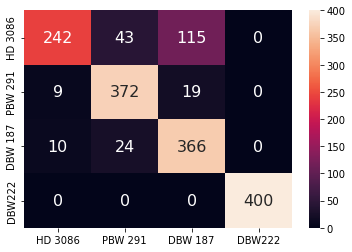

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()